# 	Investigating gene expression patterns across different neuroblastoma conditions using single-cell RNA-seq data
 
Note that the workflow in this notebook is adapted from the standard scRNA-seq data analysis procedure at <https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering.html>, under the BSD 3-Clause License at <https://github.com/scverse/scanpy/blob/a22997e106d0e7ff944967613d71c2d41d0da89a/LICENSE>

The data is obtained from "Fetahu IS, Esser-Skala W, Dnyansagar R, Sindelar S et al. Single-cell transcriptomics and epigenomics unravel the role of monocytes in neuroblastoma bone marrow metastasis. Nat Commun 2023 Jun 26;14(1):3620. PMID: 37365178"

## Preprocessing and clustering

In [1]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

In [2]:
# Setting parameters for figure configuration  
sc.settings.set_figure_params(dpi=300)

In [3]:
# Define sample dictionary for analysis: 
# - Controls 2 and 3: benign tumors (ganglioblastoma and ganglioneuroma) without bone marrow (BM) metastases, used as controls (n=2).
# - Metastatic neuroblastoma M3,M4 with MYCN-amplified, (n=2). 
## MYCN: An oncogene often amplified in neuroblastoma, associated with aggressive tumor growth and poor prognosis. 
## Amplification of MYCN is a defining characteristic in one of the metastatic neuroblastoma subtypes.

sample_id_fn_dict = {
    "C3" : "/Users/sangeevanvellappan/Desktop/Erdos_Nov2024/Data/GSM6659416_C3_filtered_feature_bc_matrix.h5",
    "C2" : "/Users/sangeevanvellappan/Desktop/Erdos_Nov2024/Data/GSM6659415_C2_filtered_feature_bc_matrix.h5",
    "M3" : "/Users/sangeevanvellappan/Desktop/Erdos_Nov2024/Data/GSM6659422_M3_filtered_feature_bc_matrix.h5",
    "M4": "/Users/sangeevanvellappan/Desktop/Erdos_Nov2024/Data/GSM6659423_M4_filtered_feature_bc_matrix.h5",
}

ann_data_dict = {}

In [4]:
# Loop through each sample ID and file path in the sample dictionary
for sid, fn in sample_id_fn_dict.items():
    print(sid)  # Print the sample ID to track progress
    sa = sc.read_10x_h5(fn)  # Read the single-cell data from the H5 file for the current sample
    sa.var_names_make_unique()  # Ensure unique variable names in case of duplicates
    ann_data_dict[sid] = sa  # Store the annotated data in the dictionary with sample ID as the key

C3


/Users/sangeevanvellappan/anaconda3/envs/workshop_2024_v2/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/sangeevanvellappan/anaconda3/envs/workshop_2024_v2/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


C2


/Users/sangeevanvellappan/anaconda3/envs/workshop_2024_v2/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/sangeevanvellappan/anaconda3/envs/workshop_2024_v2/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


M3


/Users/sangeevanvellappan/anaconda3/envs/workshop_2024_v2/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/sangeevanvellappan/anaconda3/envs/workshop_2024_v2/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


M4


/Users/sangeevanvellappan/anaconda3/envs/workshop_2024_v2/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/sangeevanvellappan/anaconda3/envs/workshop_2024_v2/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [5]:
# Concatenate all annotated data objects from the dictionary into a single AnnData object
# - `label='batch_id'` adds a column 'batch_id' in the .obs attribute, indicating the sample ID for each observation
# - `axis=0` concatenates along the rows (cells), combining all samples vertically
# - `join='inner'` keeps only the variables (genes) that are common across all samples
# - `index_unique='-'` appends '-' to duplicate observation names to make them unique
# - `fill_value=0` fills missing values with 0 for any sparse data
ann_data = ad.concat(ann_data_dict, label='batch_id', axis=0, join='inner', index_unique='-', fill_value=0)

# Ensure that observation names (cell IDs) are unique across the combined AnnData object
ann_data.obs_names_make_unique()

# Print the count of cells in each sample (batch) after concatenation
print(ann_data.obs["batch_id"].value_counts())

# Display the combined AnnData object
ann_data


batch_id
C2    6668
M4    6257
C3    5710
M3    5195
Name: count, dtype: int64


AnnData object with n_obs × n_vars = 23830 × 33538
    obs: 'batch_id'

In [6]:
# Ensure that variable names (typically gene names) are unique across the combined AnnData object.
# This is useful to avoid conflicts in case there are duplicate gene names across different samples.
ann_data.var_names_make_unique()


In [7]:
ann_data

AnnData object with n_obs × n_vars = 23830 × 33538
    obs: 'batch_id'

The data contains between 5,000-6000 cells per sample and 33,538 measured genes. We'll now investigate these with a basic preprocessing and clustering workflow.

## Quality Control

In [8]:
# Calculate quality control (QC) metrics for the AnnData object, including the total counts per cell,
# number of genes expressed per cell, and mitochondrial gene content, adding these metrics directly to the AnnData.
sc.pp.calculate_qc_metrics(ann_data, inplace=True)

(0.0, 500.0)

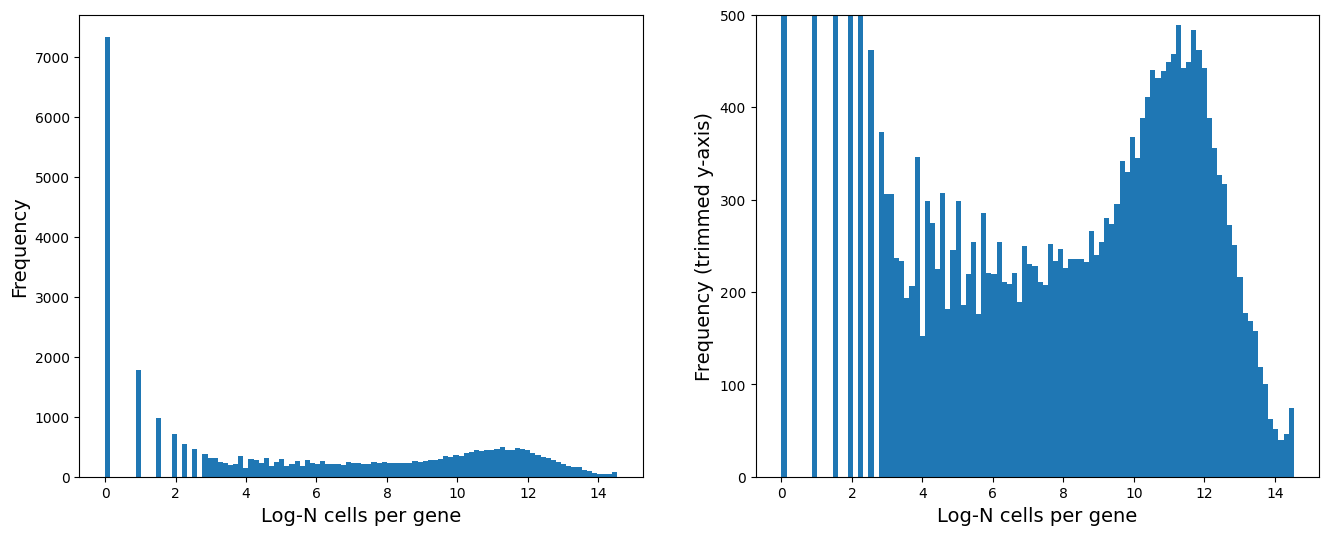

In [9]:
# Plot distribution of the number of cells in which each gene is expressed (log-transformed).
# The left panel shows the full histogram, while the right panel trims the y-axis for better visualization of low-frequency bins.
fig = plt.figure(figsize=(16, 6))

# Full distribution
ax = fig.add_subplot(1, 2, 1)
ax.hist(np.log2(ann_data.var['n_cells_by_counts'] + 1), bins=100)
ax.set_xlabel('Log-N cells per gene', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)

# Trimmed y-axis for better visualization
ax = fig.add_subplot(1, 2, 2)
ax.hist(np.log2(ann_data.var['n_cells_by_counts'] + 1), bins=100)
ax.set_xlabel('Log-N cells per gene', fontsize=14)
ax.set_ylabel('Frequency (trimmed y-axis)', fontsize=14)
ax.set_ylim([0, 500])  # Limit y-axis to highlight lower frequencies


# Interpretation of the Distribution:
In single-cell RNA sequencing (scRNA-seq), it is common to observe that many genes are expressed in only a small subset of cells (hence the high bars on the left side of the distribution). This pattern reflects the inherent heterogeneity in cell types, with each cell type expressing only a subset of all possible genes.
The goal of plotting this distribution is to assess the spread of gene expression across cells and to identify an appropriate threshold for filtering out low-expressed genes.

In [10]:
# Considering the large size of the dataset, and that we are comparing two conditions, we will remove genes expressed in less than 50 cells: 
sc.pp.filter_genes(ann_data, min_cells=100)

In [11]:
ann_data

AnnData object with n_obs × n_vars = 23830 × 15186
    obs: 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

In [13]:
# Identify Mithocondrial-genes. Removing mitochondrial genes is a common preprocessing step in single-cell RNA-seq analysis because high mitochondrial gene expression can be a sign of stressed or dying cells.
mito_genes = ann_data.var_names[ann_data.var_names.str.startswith('MT-')]

In [14]:
# now we need the row sum of the subsetted data to compute % mito content
row_sum_adata_mito = np.sum(ann_data[:, mito_genes].X.toarray(), axis = 1)

In [15]:
# compute the % of mito content by dividing the above result by library size
ann_data.obs['pct_counts_mt'] = row_sum_adata_mito/ann_data.obs['total_counts'] * 100

In [16]:
# mitochondrial genes, "MT-" for human
ann_data.var["mt"] = ann_data.var_names.str.startswith("MT-")
# ribosomal genes
ann_data.var["ribo"] = ann_data.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
ann_data.var["hb"] = ann_data.var_names.str.contains("^HB[^(P)]")

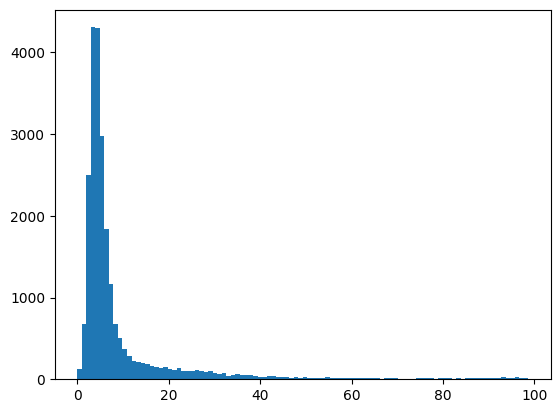

In [17]:
plt.hist(ann_data.obs['pct_counts_mt'], 100);

In [18]:
# Ribosomal genes (those starting with "RPS" for ribosomal protein small subunit and "RPL" for ribosomal protein large subunit) are also often filtered out in single-cell RNA-seq analysis because they can dominate the transcriptional profile. High ribosomal gene expression can indicate cells in high metabolic or proliferative states, which might skew analyses, especially when the focus is on non-proliferative cellular signals. Removing these genes helps focus on more informative genes relevant to cell identity and function, reducing technical noise and improving the interpretability of cell clusters.
ribo_genes = ann_data.var_names[ann_data.var_names.str.startswith(('RPS', 'RPL'))]

In [19]:
# now we need the row sum of the subsetted data to compute % mito content
row_sum_adata_ribo = np.sum(ann_data[:, ribo_genes].X.toarray(), axis = 1)

In [20]:
# compute the % of ribo content by dividing the above result by library size
ann_data.obs['pct_counts_ribo'] = row_sum_adata_ribo/ann_data.obs['total_counts'] * 100

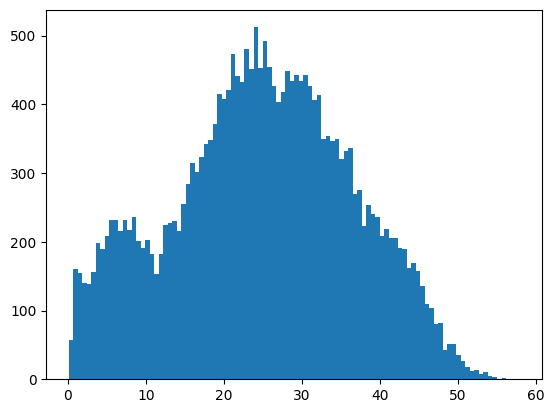

In [21]:
plt.hist(ann_data.obs['pct_counts_ribo'], 100);

For the sake of exposition, the following code removes cells with MT-content greater than 25%.

In [26]:
adata_clean = ann_data[ann_data.obs['pct_counts_mt'] < 15, :]

In [27]:
adata_clean

View of AnnData object with n_obs × n_vars = 20382 × 15186
    obs: 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pct_counts_mt', 'pct_counts_ribo'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mt', 'ribo', 'hb'

Text(0, 0.5, 'Frequency')

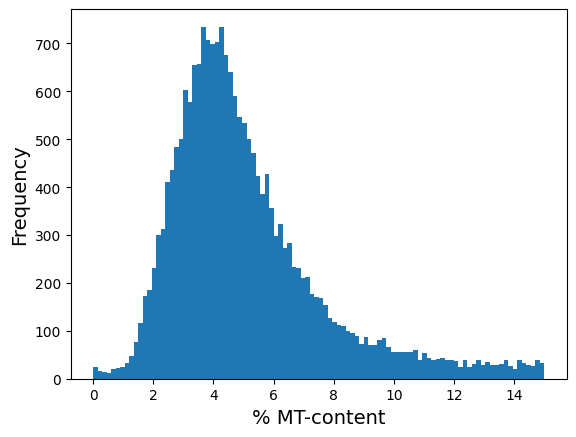

In [28]:
# just double check: there must be no cell with MT > 15
plt.hist(adata_clean.obs['pct_counts_mt'], 100);
plt.xlabel('% MT-content', fontsize = 14)
plt.ylabel('Frequency', fontsize = 14)

In [29]:
adata_clean2 = adata_clean[adata_clean.obs['pct_counts_ribo'] < 15, :]

In [30]:
adata_clean2 = adata_clean[:, ~adata_clean.var_names.str.startswith(('RPS', 'RPL'))]

In [31]:
adata_clean2

View of AnnData object with n_obs × n_vars = 20382 × 15090
    obs: 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pct_counts_mt', 'pct_counts_ribo'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mt', 'ribo', 'hb'

In [32]:
adata_clean2.write_h5ad('/Users/sangeevanvellappan/Desktop/Erdos_Nov2024/Data/processed_adata.h5ad')